In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/PFE/Model/Horse Gait Recognition

/content/drive/MyDrive/PFE/Model/Horse Gait Recognition


In [ ]:
import pickle

import torch
import math
import numpy as np
import argparse
import os
import torch.nn as nn


# Define directory path for your data
data_dir = r"/content/drive/MyDrive/PFE/Model/Horse_Gait_Recognition/Data/Extracted/xsub"

# Define filenames for training and testing data (assuming .npy format)
file_train = 'train_data_joint_pad.npy'
file_test = 'val_data_joint_pad.npy'

print('loading data')
X_train = np.load(os.path.join(data_dir,file_train),  allow_pickle=True)
X_test = np.load(os.path.join(data_dir,file_test), allow_pickle=True)
y_train = np.load(os.path.join(data_dir,'train_labels_pad.pkl'), allow_pickle=True)
y_test = np.load(os.path.join(data_dir,'val_labels_pad.pkl'), allow_pickle=True)

y_train = y_train[1]

y_test = y_test[1]


X_train = X_train.transpose(0, 2 ,3 , 1)
print(X_train.shape)
X_test= X_test.transpose(0, 2 ,3 , 1)
print(X_test.shape)

def load_data_labels(data_dir, set_name):

    with open(os.path.join(data_dir, f'{set_name}_labels_pad.pkl'), 'rb') as f:
        labels = pickle.load(f)
    return  labels

# Example usage
y_train = load_data_labels(data_dir, 'train')
y_test = load_data_labels(data_dir, 'val')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


loading data
(137, 50, 28, 2)
(34, 50, 28, 2)
(137, 50, 28, 2)
(34, 50, 28, 2)
(137,)
(34,)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def calculate_reference_length(sequence):
    withers_position = sequence[:, 13, :]
    poll_position = sequence[:, 2, :]

    distances = np.sqrt(np.sum((withers_position - poll_position)**2, axis=1))
    return np.mean(distances)

def extract_hoof_data(sequence):
    LEFT_FRONT_HOOF = 12
    RIGHT_FRONT_HOOF = 8
    LEFT_HIND_HOOF = 23
    RIGHT_HIND_HOOF = 19

    return {
        'LF': sequence[:, LEFT_FRONT_HOOF],
        'RF': sequence[:, RIGHT_FRONT_HOOF],
        'LH': sequence[:, LEFT_HIND_HOOF],
        'RH': sequence[:, RIGHT_HIND_HOOF]
    }

def detect_peaks(data, height_factor=0.5, distance_factor=0.26):
    height = np.mean(data) + height_factor * np.std(data)
    distance = int(len(data) * distance_factor)
    peaks, _ = find_peaks(data, height=height, distance=distance)
    return peaks

def calculate_normalized_stride_length(sequence, hoof_data, peaks, reference_length):
    if len(peaks) < 2:
        return 0

    x_positions = hoof_data[:, 0]
    stride_lengths = np.abs(np.diff(x_positions[peaks]))
    avg_stride_length = np.mean(stride_lengths)

    return avg_stride_length / reference_length

def calculate_stride_frequency(peaks, total_frames=50, fps=30):
    if len(peaks) < 2:
        return 0

    intervals = np.diff(peaks)
    avg_interval = np.mean(intervals)

    frequency = fps / avg_interval
    return frequency

def analyze_gait(sequence):
    reference_length = calculate_reference_length(sequence)
    hoof_data = extract_hoof_data(sequence)
    results = {}

    for hoof, data in hoof_data.items():
        peaks = detect_peaks(data[:, 1])  # Use vertical position for peak detection
        normalized_stride_length = calculate_normalized_stride_length(sequence, data, peaks, reference_length)
        stride_frequency = calculate_stride_frequency(peaks)

        results[hoof] = {
            'peaks': peaks,
            'normalized_stride_length': normalized_stride_length,
            'stride_frequency': stride_frequency
        }

    return results

def plot_gait_sequence(sequence, results, index, gait_type):
    hoof_data = extract_hoof_data(sequence)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{gait_type.capitalize()} Gait Analysis - Sequence {index}', fontsize=16)

    for i, (hoof, data) in enumerate(hoof_data.items()):
        row = i // 2
        col = i % 2

        axs[row, col].plot(data[:, 1], label='Vertical Position')
        axs[row, col].plot(results[hoof]['peaks'], data[results[hoof]['peaks'], 1], 'ro', label='Peaks')

        axs[row, col].set_title(f'{hoof} - Normalized Stride Length: {results[hoof]["normalized_stride_length"]:.4f}\n'
                                f'Stride Frequency: {results[hoof]["stride_frequency"]:.2f} Hz')
        axs[row, col].set_xlabel('Frame')
        axs[row, col].set_ylabel('Vertical Position')
        axs[row, col].legend()

    plt.tight_layout()
    plt.show()

def calculate_gait_parameters(results):
    frequencies = [results[hoof]['stride_frequency'] for hoof in ['LF', 'RF', 'LH', 'RH']]
    lengths = [results[hoof]['normalized_stride_length'] for hoof in ['LF', 'RF']]  # Only front feet

    non_zero_frequencies = [freq for freq in frequencies if freq != 0]
    non_zero_lengths = [length for length in lengths if length != 0]

    freq = min(non_zero_frequencies) if non_zero_frequencies else 0
    length = np.mean(non_zero_lengths) if non_zero_lengths else 0

    return freq, length

def clean_gait_parameters(row, thresholds):
    stride_freq = row['stride_frequency']
    stride_length = row['normalized_stride_length']
    gait_label = row['gait_type']

    # Replace 0 with NaN
    if stride_freq == 0 or stride_length == 0:
        return np.nan, np.nan

    # Check against class-specific thresholds for frequency only
    if gait_label in thresholds:
        if stride_freq > thresholds[gait_label]:
            return np.nan, np.nan

    # For canter, ensure frequency is not smaller than 1.5
    if gait_label == 'canter' and stride_freq < 1.5:
        return np.nan, np.nan

    return stride_freq, stride_length

# Initialize an empty DataFrame to store the features
features_df = pd.DataFrame()

# Process all sequences
for i, (sequence, label) in enumerate(zip(X_train, y_train)):
    gait_type = ['walk', 'trot', 'canter'][label]
    results = analyze_gait(sequence)
    plot_gait_sequence(sequence, results, i+1, gait_type)

    stride_freq, normalized_stride_length = calculate_gait_parameters(results)

    # Add extracted features to the DataFrame
    new_row = pd.DataFrame([{
        'gait_type': gait_type,
        'stride_frequency': stride_freq,
        'normalized_stride_length': normalized_stride_length,
        **{f'{hoof}_{key}': value
           for hoof, hoof_results in results.items()
           for key, value in hoof_results.items()
           if key not in ['peaks']}
    }])

    features_df = pd.concat([features_df, new_row], ignore_index=True)

# Define thresholds for data cleaning (frequency only)
thresholds = {
    'walk': 1.2,
    'trot': 1.5
}

# Apply data cleaning
features_df['cleaned_stride_frequency'], features_df['cleaned_normalized_stride_length'] = zip(
    *features_df.apply(lambda row: clean_gait_parameters(row, thresholds), axis=1)
)

# Display the resulting DataFrame
print(features_df)

# Optional: Save the DataFrame to a CSV file
features_df.to_csv('analysis_results.csv', index=False)

Output hidden; open in https://colab.research.google.com to view.

NaN counts per gait:
           NaN Count (Frequency)  NaN Count (Length)
gait_type                                           
canter                        24                  24
trot                           3                   3
walk                          14                  14


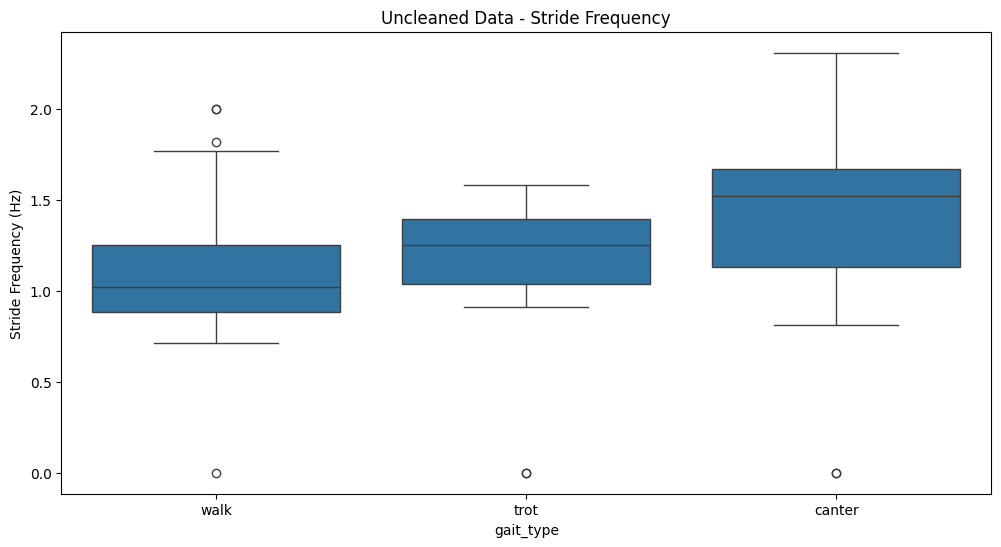

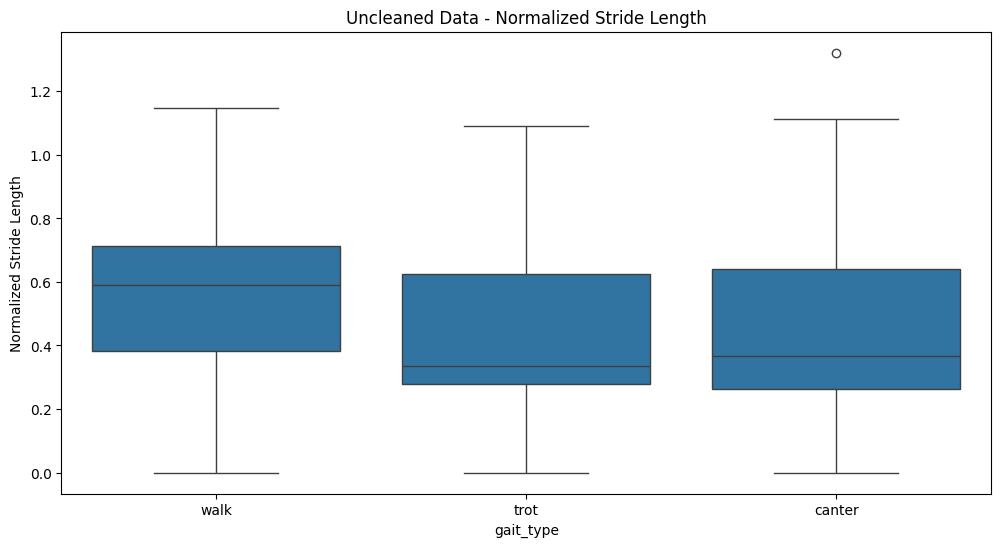

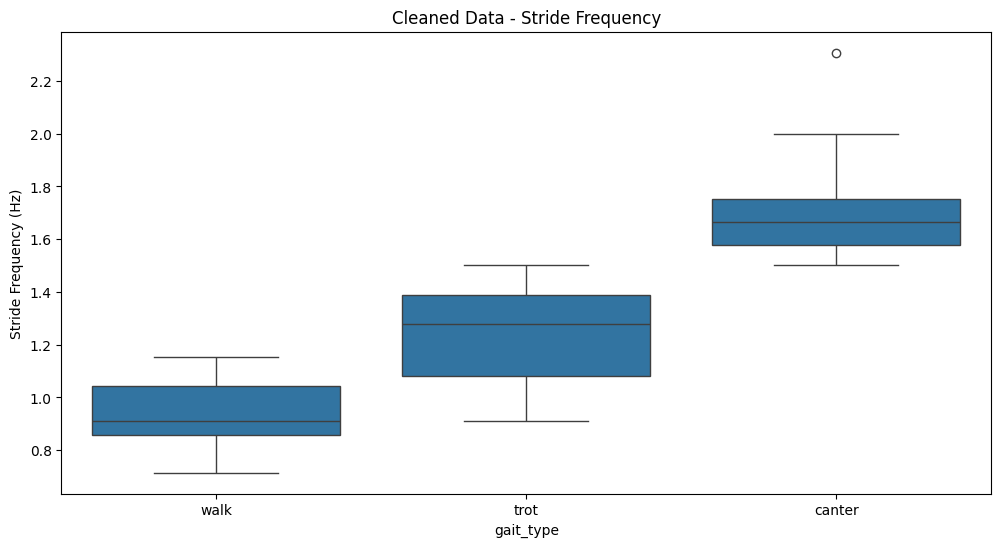

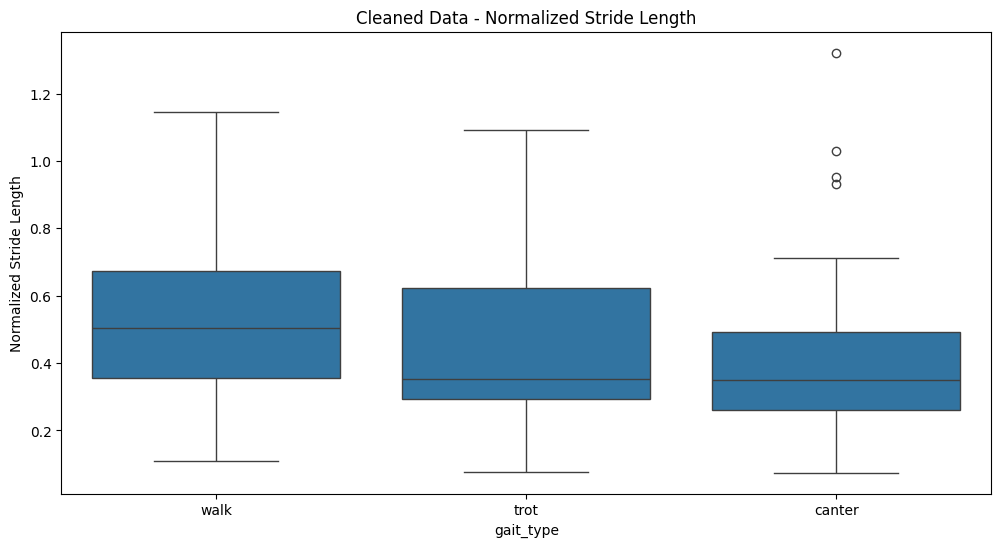


Uncleaned Data Statistics:

Walk:
Stride Frequency:
count    46.000000
mean      1.100405
std       0.384417
min       0.000000
25%       0.882353
50%       1.017241
75%       1.250000
max       2.000000
Name: stride_frequency, dtype: float64

Normalized Stride Length:
count    46.000000
mean      0.577955
std       0.265325
min       0.000000
25%       0.383684
50%       0.589224
75%       0.714418
max       1.145897
Name: normalized_stride_length, dtype: float64

Trot:
Stride Frequency:
count    41.000000
mean      1.183057
std       0.326695
min       0.000000
25%       1.034483
50%       1.250000
75%       1.395349
max       1.578947
Name: stride_frequency, dtype: float64

Normalized Stride Length:
count    41.000000
mean      0.452082
std       0.296111
min       0.000000
25%       0.279603
50%       0.336524
75%       0.625277
max       1.090559
Name: normalized_stride_length, dtype: float64

Canter:
Stride Frequency:
count    50.000000
mean      1.395109
std       0.441183
min 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Count NaN values per gait for cleaned frequency and length
nan_counts = features_df.groupby('gait_type').agg({
    'cleaned_stride_frequency': lambda x: x.isna().sum(),
    'cleaned_normalized_stride_length': lambda x: x.isna().sum()
})
nan_counts.columns = ['NaN Count (Frequency)', 'NaN Count (Length)']
print("NaN counts per gait:")
print(nan_counts)

# Function to create boxplots
def create_boxplots(data, is_cleaned, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='gait_type', y='stride_frequency' if not is_cleaned else 'cleaned_stride_frequency', data=data)
    plt.title(f'{title} - Stride Frequency')
    plt.ylabel('Stride Frequency (Hz)')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='gait_type', y='normalized_stride_length' if not is_cleaned else 'cleaned_normalized_stride_length', data=data)
    plt.title(f'{title} - Normalized Stride Length')
    plt.ylabel('Normalized Stride Length')
    plt.show()

# Create boxplots for uncleaned data
create_boxplots(features_df, False, 'Uncleaned Data')

# Create boxplots for cleaned data
create_boxplots(features_df, True, 'Cleaned Data')

# Calculate and print statistics for both cleaned and uncleaned data
def print_statistics(data, is_cleaned, title):
    print(f"\n{title} Statistics:")
    for gait in ['walk', 'trot', 'canter']:
        gait_data = data[data['gait_type'] == gait]
        freq_col = 'stride_frequency' if not is_cleaned else 'cleaned_stride_frequency'
        length_col = 'normalized_stride_length' if not is_cleaned else 'cleaned_normalized_stride_length'

        freq_stats = gait_data[freq_col].describe()
        length_stats = gait_data[length_col].describe()

        print(f"\n{gait.capitalize()}:")
        print("Stride Frequency:")
        print(freq_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])
        print("\nNormalized Stride Length:")
        print(length_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# Print statistics for uncleaned data
print_statistics(features_df, False, 'Uncleaned Data')

# Print statistics for cleaned data
print_statistics(features_df, True, 'Cleaned Data')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def process_dataset(X, y, dataset_name):
    features_df = pd.DataFrame()

    for i, (sequence, label) in enumerate(zip(X, y)):
        gait_type = ['walk', 'trot', 'canter'][label]
        results = analyze_gait(sequence)
        #plot_gait_sequence(sequence, results, i+1, f"{dataset_name} - {gait_type}")

        stride_freq, normalized_stride_length = calculate_gait_parameters(results)

        new_row = pd.DataFrame([{
            'gait_type': gait_type,
            'stride_frequency': stride_freq,
            'normalized_stride_length': normalized_stride_length,
            **{f'{hoof}_{key}': value
               for hoof, hoof_results in results.items()
               for key, value in hoof_results.items()
               if key not in ['peaks']}
        }])

        features_df = pd.concat([features_df, new_row], ignore_index=True)

    # Define thresholds for data cleaning (frequency only)
    thresholds = {
        'walk': 1.2,
        'trot': 1.5
    }

    # Apply data cleaning
    features_df['cleaned_stride_frequency'], features_df['cleaned_normalized_stride_length'] = zip(
        *features_df.apply(lambda row: clean_gait_parameters(row, thresholds), axis=1)
    )

    # Save the DataFrame to a CSV file
    features_df.to_csv(f'analysis_results_{dataset_name}.csv', index=False)

    return features_df

# Process training data
print("Processing training data...")
train_df = process_dataset(X_train, y_train, "train")

# Process testing data
print("Processing testing data...")
test_df = process_dataset(X_test, y_test, "test")

# Display the resulting DataFrames
print("Training data:")
print(train_df)
print("\nTesting data:")
print(test_df)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Processing training data...
Processing testing data...
Training data:
    gait_type  stride_frequency  normalized_stride_length  \
0        walk          1.071429                  0.717657   
1        walk          1.153846                  0.874742   
2        walk          1.304348                  0.665579   
3        walk          1.304348                  0.665579   
4        walk          0.882353                  1.110802   
..        ...               ...                       ...   
132    canter          0.810811                  0.842343   
133    canter          1.500000                  0.381742   
134    canter          1.578947                  0.932452   
135    canter          1.428571                  0.383800   
136    canter          1.428571                  0.383800   

     LF_normalized_stride_length  LF_stride_frequency  \
0                       0.799610             1.200000   
1                       0.873859             1.818182   
2                       0.

In [ ]:
# Read the CSV file we created earlier
gait_df = pd.read_csv('analysis_results_train.csv')
df = pd.read_csv(r'/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_16_train.csv')
# Extract the columns we need
gait_features = gait_df[['normalized_stride_length', 'cleaned_stride_frequency']]

# Rename the columns for clarity
gait_features = gait_features.rename(columns={
    'normalized_stride_length': 'gait_normalized_stride_length',
    'cleaned_stride_frequency': 'gait_cleaned_stride_frequency'
})

# Concatenate the dataframes
final_df = pd.concat([df, gait_features], axis=1)

# Save the final dataframe to a new CSV
final_df.to_csv('horse_gait_combined_features_train.csv', index=False)

print("Combined features saved to 'horse_gait_combined_features_train.csv'")
print(f"Shape of the final dataframe: {final_df.shape}")
print("\nFirst few rows of the final dataframe:")
print(final_df.head())

Combined features saved to 'horse_gait_combined_features_train.csv'
Shape of the final dataframe: (137, 20)

First few rows of the final dataframe:
   front_pattern_regularity  hind_pattern_regularity  \
0                  6.925289                 6.399449   
1                  7.447668                 6.190774   
2                  7.446828                 5.724098   
3                  7.446828                 5.724098   
4                 13.280930                13.277041   

   front_left_right_correlation  hind_left_right_correlation  \
0                      0.404734                     0.418335   
1                      0.118477                     0.448368   
2                     -0.260122                    -0.050301   
3                     -0.260122                    -0.050301   
4                      0.364891                     0.058195   

   LF_vertical_range  LF_skewness  LF_kurtosis  RF_vertical_range  \
0           0.290929    -1.128159     0.891437           0.16

In [ ]:
import pandas as pd

# Read the CSV files
gait_df = pd.read_csv('analysis_results_train.csv')
df = pd.read_csv(r'/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_16_train.csv')

# Extract the columns we need
gait_features = gait_df[['normalized_stride_length', 'cleaned_stride_frequency']]

# Rename the columns for clarity
gait_features = gait_features.rename(columns={
    'normalized_stride_length': 'gait_normalized_stride_length',
    'cleaned_stride_frequency': 'gait_cleaned_stride_frequency'
})

# Find the index of 'sequence_id' column
sequence_id_index = df.columns.get_loc('sequence_id')

# Insert the new features before 'sequence_id'
for i, col in enumerate(gait_features.columns):
    df.insert(sequence_id_index + i, col, gait_features[col])

# Save the final dataframe to a new CSV
df.to_csv('/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_combined_features_train.csv', index=False)

print("Combined features saved to 'horse_gait_combined_features_train.csv'")
print(f"Shape of the final dataframe: {df.shape}")
print("\nFirst few rows of the final dataframe:")
print(df.head())

# Verify the order of columns
print("\nColumn order:")
print(df.columns.tolist())

Combined features saved to 'horse_gait_combined_features_train.csv'
Shape of the final dataframe: (137, 20)

First few rows of the final dataframe:
   front_pattern_regularity  hind_pattern_regularity  \
0                  6.925289                 6.399449   
1                  7.447668                 6.190774   
2                  7.446828                 5.724098   
3                  7.446828                 5.724098   
4                 13.280930                13.277041   

   front_left_right_correlation  hind_left_right_correlation  \
0                      0.404734                     0.418335   
1                      0.118477                     0.448368   
2                     -0.260122                    -0.050301   
3                     -0.260122                    -0.050301   
4                      0.364891                     0.058195   

   LF_vertical_range  LF_skewness  LF_kurtosis  RF_vertical_range  \
0           0.290929    -1.128159     0.891437           0.16

In [ ]:
import pandas as pd

# Read the CSV files
gait_df = pd.read_csv('analysis_results_test.csv')
df = pd.read_csv(r'/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_16_test.csv')

# Extract the columns we need
gait_features = gait_df[['normalized_stride_length', 'cleaned_stride_frequency']]

# Rename the columns for clarity
gait_features = gait_features.rename(columns={
    'normalized_stride_length': 'gait_normalized_stride_length',
    'cleaned_stride_frequency': 'gait_cleaned_stride_frequency'
})

# Find the index of 'sequence_id' column
sequence_id_index = df.columns.get_loc('sequence_id')

# Insert the new features before 'sequence_id'
for i, col in enumerate(gait_features.columns):
    df.insert(sequence_id_index + i, col, gait_features[col])

# Save the final dataframe to a new CSV
df.to_csv('/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_combined_features_test.csv', index=False)

print("Combined features saved to 'horse_gait_combined_features_test.csv'")
print(f"Shape of the final dataframe: {df.shape}")
print("\nFirst few rows of the final dataframe:")
print(df.head())

# Verify the order of columns
print("\nColumn order:")
print(df.columns.tolist())

Combined features saved to 'horse_gait_combined_features_test.csv'
Shape of the final dataframe: (34, 20)

First few rows of the final dataframe:
   front_pattern_regularity  hind_pattern_regularity  \
0                 12.357062                10.041922   
1                 14.154639                 6.646991   
2                 14.154639                 6.646991   
3                 20.627121                 7.736132   
4                 24.946180                 7.704174   

   front_left_right_correlation  hind_left_right_correlation  \
0                     -0.634512                    -0.288654   
1                     -0.314318                    -0.105086   
2                     -0.314318                    -0.105086   
3                     -0.273837                     0.556225   
4                     -0.075190                     0.807462   

   LF_vertical_range  LF_skewness  LF_kurtosis  RF_vertical_range  \
0           0.151606    -0.163694    -0.045954           0.1607

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# Prepare the data for the classifier
df_train = pd.read_csv('horse_gait_combined_features_train.csv')
X_train = df_train.drop(['sequence_id', 'label'], axis=1)
y_train = df_train['label']
df_test = pd.read_csv('/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_combined_features_test.csv')
X_test = df_test.drop(['sequence_id', 'label'], axis=1)
y_test = df_test['label']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Create and train the Random Forest Classifier with adjusted parameters
rf_classifier = RandomForestClassifier(n_estimators=200,
                                       min_samples_split=5,
                                       min_samples_leaf=2,
                                       max_depth=10,
                                       max_features='sqrt',
                                       random_state=42)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier, X_train_selected, y_train, cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV score:", cv_scores.std())

# Fit the model on the entire training set
rf_classifier.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_selected)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
selected_features = X_train.columns[selector.get_support()]
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Save the model and scaler (optional)
import joblib
joblib.dump(rf_classifier, 'random_forest_model_tuned.joblib')
joblib.dump(scaler, 'scaler_tuned.joblib')
joblib.dump(selector, 'feature_selector.joblib')

Cross-validation scores: [0.96428571 0.78571429 0.96296296 0.88888889 1.        ]
Mean CV score: 0.9203703703703703
Standard deviation of CV score: 0.07642893313541542

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00        10

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34


Confusion Matrix:
[[12  0  0]
 [ 1 11  0]
 [ 0  0 10]]

Feature Importance:
                         feature  importance
8  gait_cleaned_stride_frequency    0.247645
0       front_pattern_regularity    0.150405
2   front_left_right_correlation    0.120126
5                    RF_skewness    0.111090
1        hind_pattern_regularity    0.110646
4              RF_vertical_range    0.081995
3                    LF_skewness   

['feature_selector.joblib']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist,
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    min_samples_leaf=2,
                                                    min_samples_split=5,
                                                    n_estimators=200,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# Prepare the data for the classifier
df_train = pd.read_csv('/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_combined_features_train.csv')
X_train = df_train.drop(['sequence_id', 'label'], axis=1)
y_train = df_train['label']
df_test = pd.read_csv('/content/drive/MyDrive/PFE/Model/Horse Gait Recognition/data/horse_gait_combined_features_test.csv')
X_test = df_test.drop(['sequence_id', 'label'], axis=1)
y_test = df_test['label']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Create and train the Random Forest Classifier with adjusted parameters
rf_classifier = RandomForestClassifier(max_features='log2', min_samples_leaf=4,
                       n_estimators=200, random_state=42)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier, X_train_selected, y_train, cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV score:", cv_scores.std())

# Fit the model on the entire training set
rf_classifier.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_selected)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
selected_features = X_train.columns[selector.get_support()]
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Save the model and scaler (optional)
import joblib
joblib.dump(rf_classifier, 'random_forest_model_tuned.joblib')
joblib.dump(scaler, 'scaler_tuned.joblib')
joblib.dump(selector, 'feature_selector.joblib')

Cross-validation scores: [0.92857143 0.75       0.96296296 0.88888889 0.96296296]
Mean CV score: 0.8986772486772487
Standard deviation of CV score: 0.07919558620981017

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00        10

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34


Confusion Matrix:
[[12  0  0]
 [ 1 11  0]
 [ 0  0 10]]

Feature Importance:
                         feature  importance
8  gait_cleaned_stride_frequency    0.245601
0       front_pattern_regularity    0.151049
2   front_left_right_correlation    0.120493
1        hind_pattern_regularity    0.116122
5                    RF_skewness    0.106668
4              RF_vertical_range    0.079259
7              LH_vertical_range   

['feature_selector.joblib']

Text(170.72222222222223, 0.5, 'True Label')

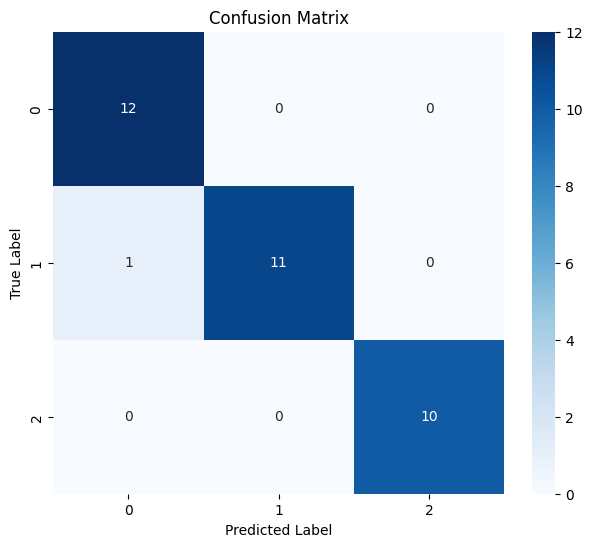

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the matplotlib figure
plt.figure(figsize=(16, 6))

# 1. Confusion Matrix Visualization
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

